#  ENSIMAG WIND POWER FORECASTING 2024
Note:  Les traductions de l’anglais vers le français ont été réalisées dans Google Translate.  

Translations from English to French are included since the original Kaggle competition was provided in French.

## 1. Project Objective (Objectif du projet):


###  Objectives:
-  Evaluate the wind turbine power dataset and understand the relationships in the data.
-  Develop a model to predict wind turbine output.

###  Data Contents:
- date: Self-explanatory. 
- u10: Forecast zonal wind velocity (m/s) at 10m above ground. 
- v10: Forecast meridional wind velocity (m/s) at 10m above ground. 
- u100: Forecast zonal wind velocity (m/s) at 100m above ground. 
- v100: Forecast meridional wind velocity (m/s) at 100m above ground.   
- production: Hourly-mean wind power normalised by the maximum output of the wind farm. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings

#  import libaries
import os
os.environ["OMP_NUM_THREADS"] = '5'

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import math


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ensimag-mmis-2024/sample.csv
/kaggle/input/ensimag-mmis-2024/train.csv
/kaggle/input/ensimag-mmis-2024/test.csv


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)


## 2. Data Input (Entrée de données)

In [3]:
df_train = pd.read_csv('/kaggle/input/ensimag-mmis-2024/train.csv')
df_test = pd.read_csv('/kaggle/input/ensimag-mmis-2024/test.csv')
df_sample = pd.read_csv('/kaggle/input/ensimag-mmis-2024/sample.csv')

In [4]:
#  Format required for the Submission file
df_sample.head()

date  production
0  2021-01-01 00:00:00        0.25
1  2021-01-01 01:00:00        0.25
2  2021-01-01 02:00:00        0.25
3  2021-01-01 03:00:00        0.25
4  2021-01-01 04:00:00        0.25

In [5]:
df_train.head()
orig_columns = df_train.columns
#  Data looks like hourly data.

## 3.  Data Cleaning (Nettoyage des données)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        8783 non-null   object 
 1   u10         8783 non-null   float64
 2   v10         8783 non-null   float64
 3   u100        8783 non-null   float64
 4   v100        8783 non-null   float64
 5   production  8783 non-null   float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [7]:
df_train.isna().sum()

date          0
u10           0
v10           0
u100          0
v100          0
production    0
dtype: int64

In [8]:
#  Confirm date column is in datetime in train and test dfs
df_train.date = pd.to_datetime(df_train.date)
pd.api.types.is_datetime64_any_dtype(df_train.date)
#  Change the date format to df_test
df_test.date = pd.to_datetime(df_test.date)
pd.api.types.is_datetime64_any_dtype(df_test.date)

True

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        8783 non-null   datetime64[ns]
 1   u10         8783 non-null   float64       
 2   v10         8783 non-null   float64       
 3   u100        8783 non-null   float64       
 4   v100        8783 non-null   float64       
 5   production  8783 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 411.8 KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7982 entries, 0 to 7981
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7982 non-null   datetime64[ns]
 1   u10     7982 non-null   float64       
 2   v10     7982 non-null   float64       
 3   u100    7982 non-null   float64       
 4   v100    7982 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 311.9 KB


## 4. Exploratory Data Analysis (Analyse exploratoire des données)

In [11]:
df_train.corr()['production'].sort_values(ascending=False)

production    1.000000
u10           0.318136
u100          0.307901
date         -0.048344
v10          -0.128665
v100         -0.143718
Name: production, dtype: float64

Text(0, 0.5, 'Normalized Power Output')

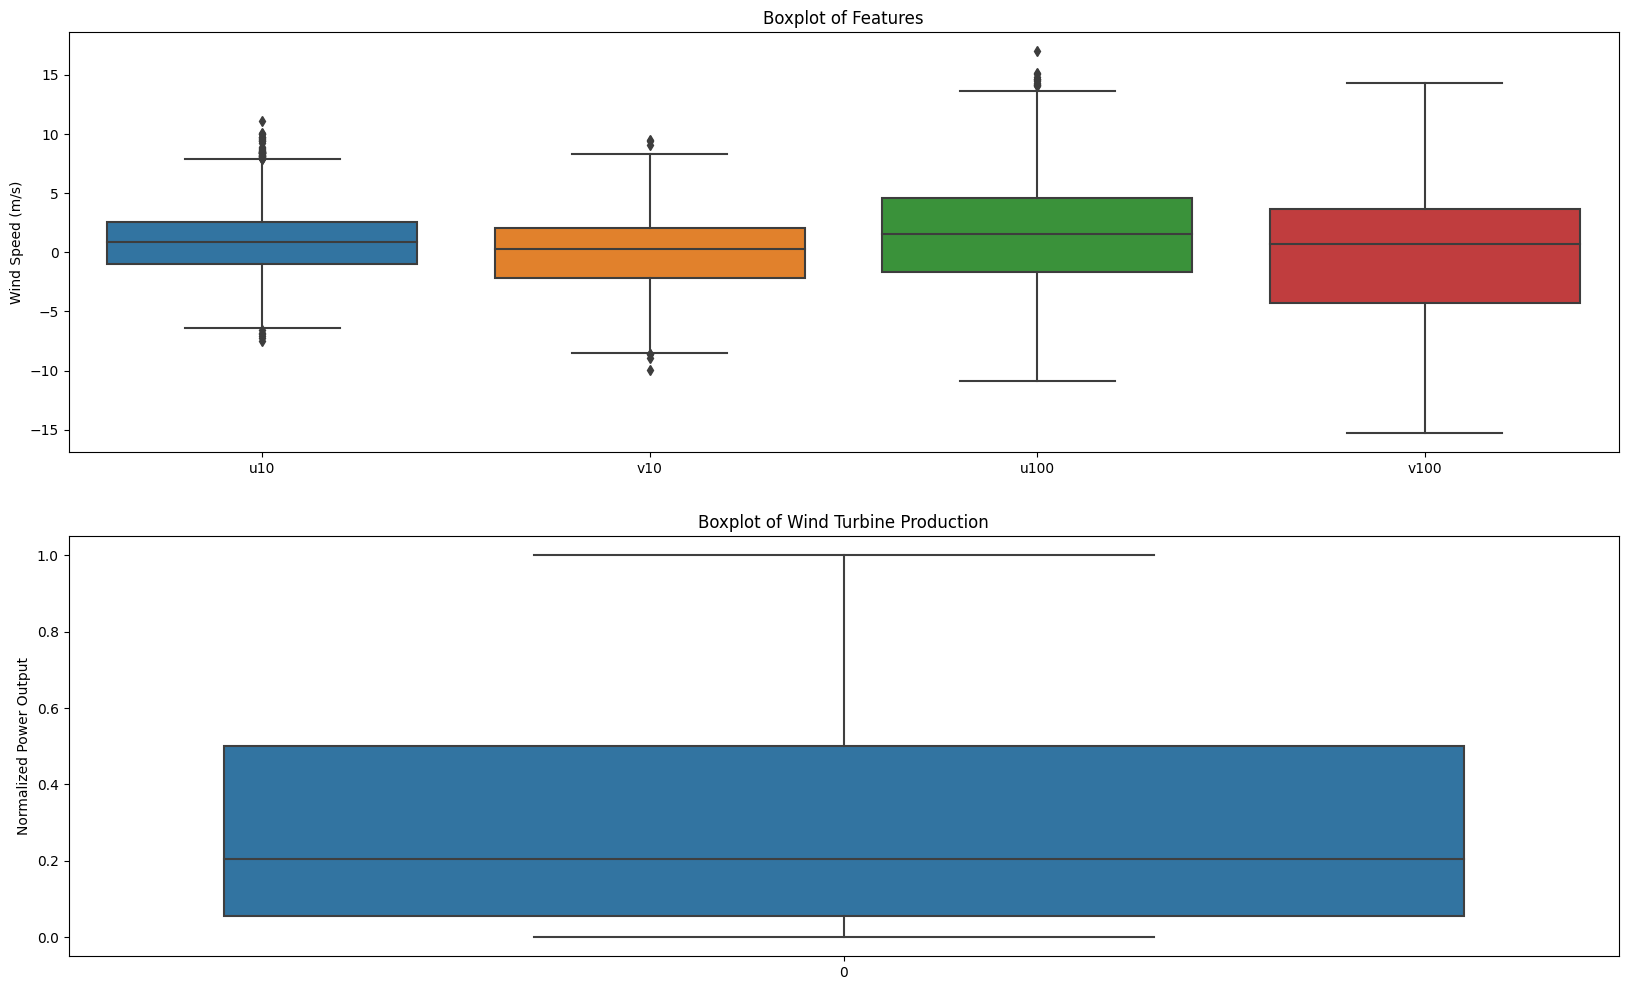

In [12]:
#  Plot 2 subplots, 1 for features and 1 for the normalized wind power output
columns = list(df_train.columns[1:-1])
_, axs = plt.subplots(2,1,figsize=(20,12))
sns.boxplot(data=df_train[columns], ax = axs[0])
axs[0].set_title('Boxplot of Features')
axs[0].set_ylabel('Wind Speed (m/s)')
sns.boxplot(data=df_train['production'], ax = axs[1])
axs[1].set_title('Boxplot of Wind Turbine Production')
axs[1].set_ylabel('Normalized Power Output')

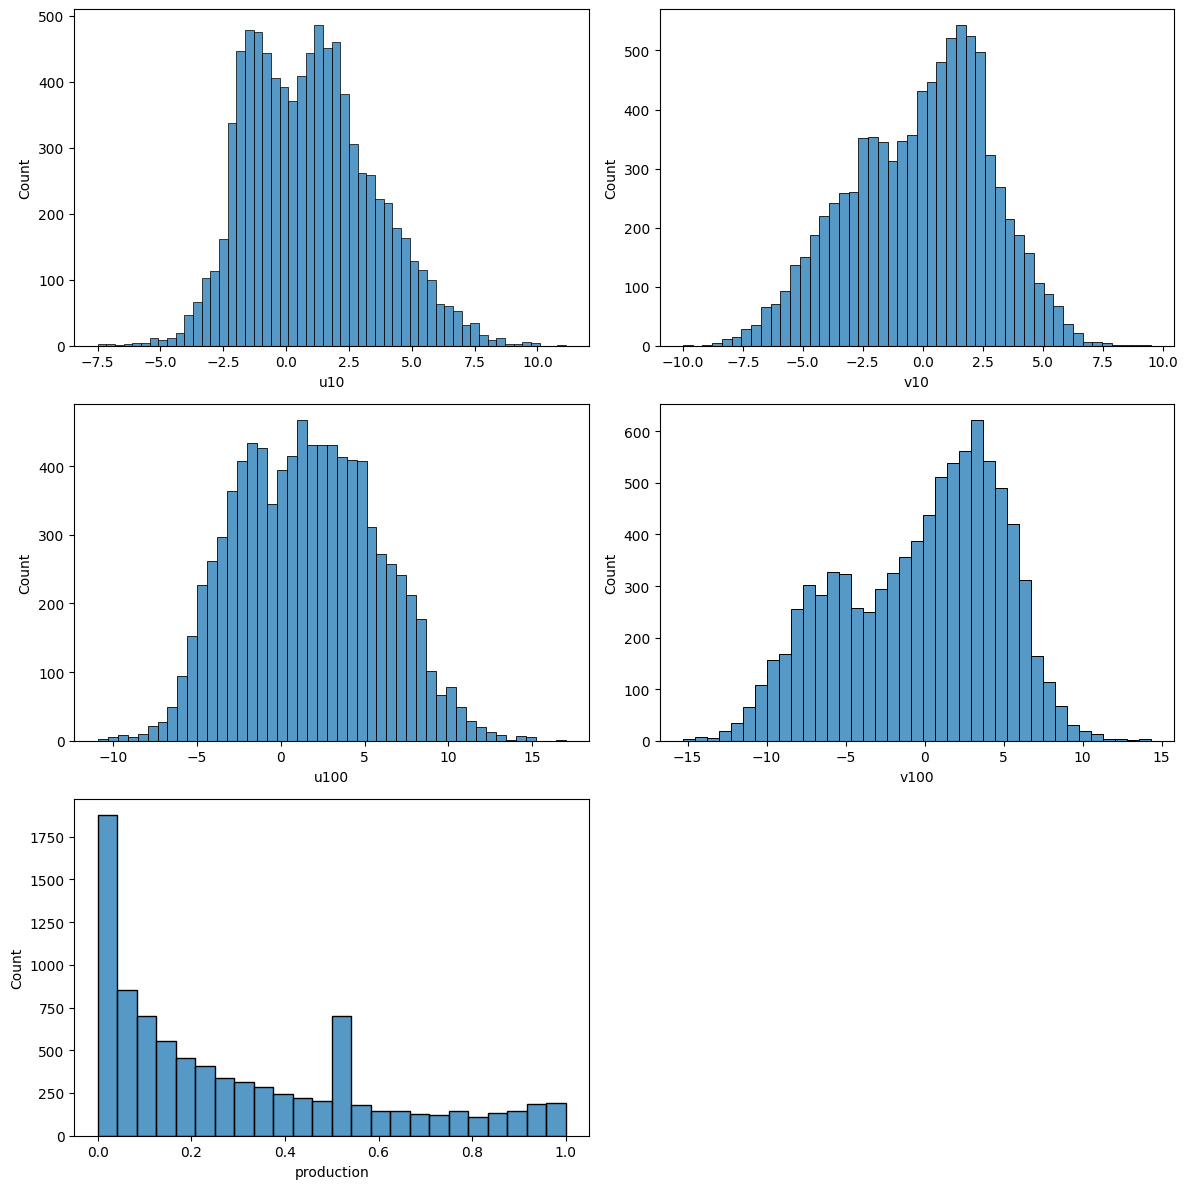

In [13]:

#  Plot a histogram of each of the features and target
#  Evaluate the distribution of the data with a boxplot
_, axs = plt.subplots(3, 2, figsize=(12,12))
axs = axs.flatten()

for i, col in enumerate(list(df_train.columns)[1:]):
     sns.histplot(data=df_train, x=col, ax = axs[i])

axs[5].set_visible(False)
plt.tight_layout()
plt.show()

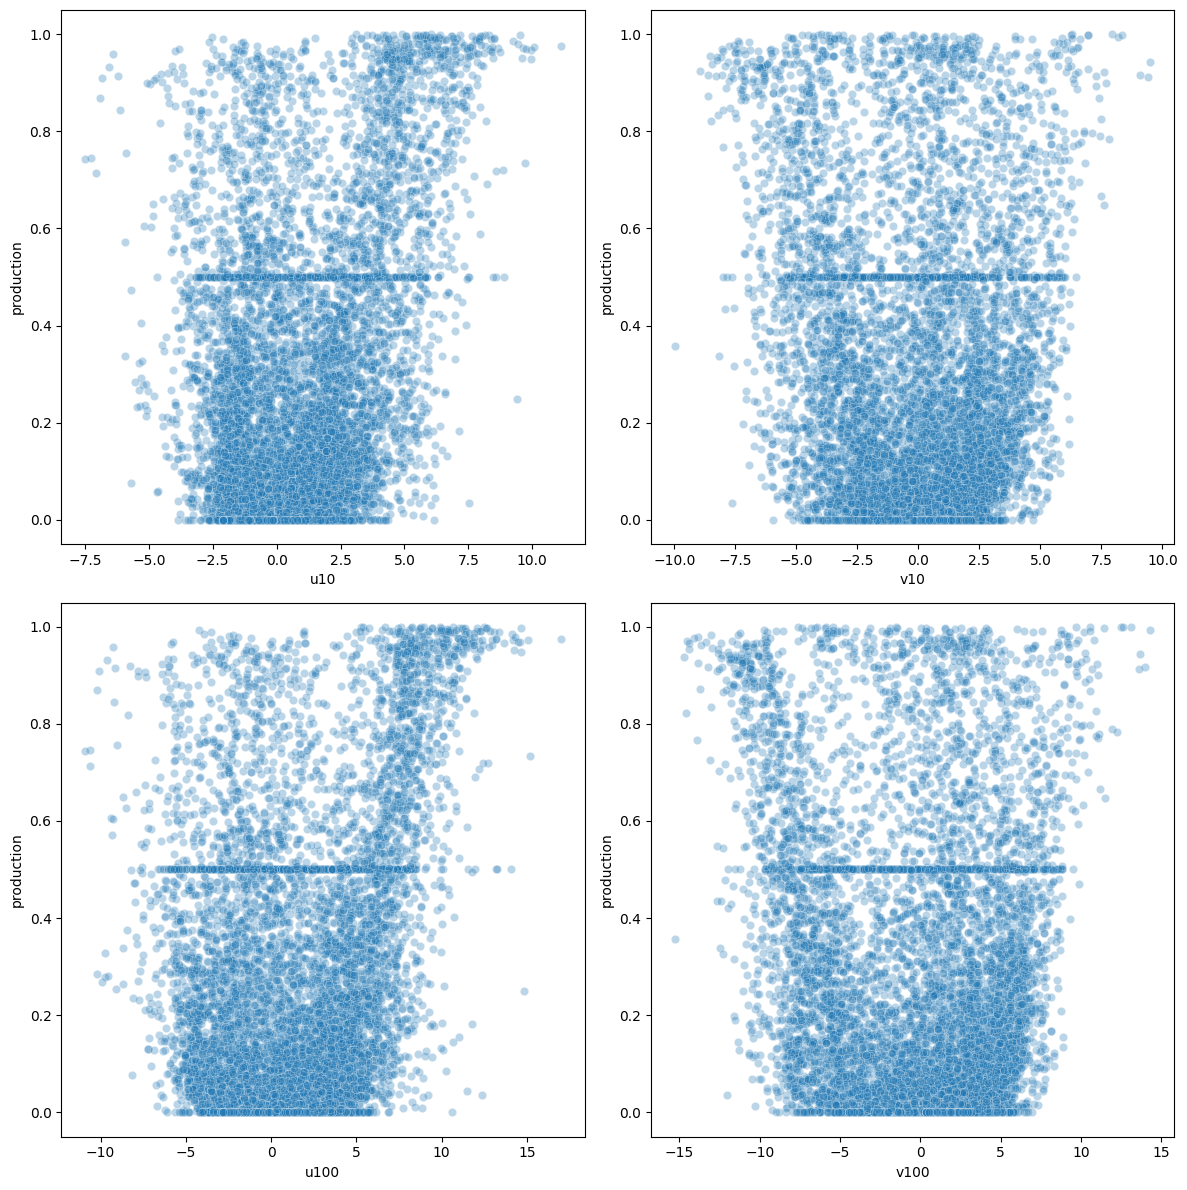

In [14]:
#  Plot an xy plot of the target vs. each of the features.

_, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()

for i, col in enumerate(list(df_train.columns)[1:-1]):
     sns.scatterplot(data=df_train, x=col, y='production', ax = axs[i], alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
#  Calculate the wind speed, and direction and plot these against the turbine output.
df_train['wind_speed_10'] = np.sqrt(df_train.u10**2 + df_train.v10**2)
df_train['wind_speed_100'] = np.sqrt(df_train.u100**2 + df_train.v100**2)

df_train['wind_direction_10'] = np.degrees(np.arctan2(df_train.v10, df_train.u10))
df_train['wind_direction_100'] = np.degrees(np.arctan2(df_train.v100, df_train.u100))

# convert negative angles to 0-360 degrees.
df_train['wind_direction_10'] = (df_train['wind_direction_10'] + 360) % 360
df_train['wind_direction_100'] = (df_train['wind_direction_100'] + 360) % 360

df_train.head()

date       u10       v10      u100      v100  production  \
0 2020-01-01 01:00:00  2.124600 -2.681966  2.864280 -3.666076    0.000000   
1 2020-01-01 02:00:00  2.521695 -1.796960  3.344859 -2.464761    0.054879   
2 2020-01-01 03:00:00  2.672210 -0.822516  3.508448 -1.214093    0.110234   
3 2020-01-01 04:00:00  2.457504 -0.143642  3.215233 -0.355546    0.165116   
4 2020-01-01 05:00:00  2.245898  0.389576  2.957678  0.332701    0.156940   

   wind_speed_10  wind_speed_100  wind_direction_10  wind_direction_100  
0       3.421530        4.652334         308.385561          308.000265  
1       3.096451        4.154892         324.526320          323.614219  
2       2.795932        3.712577         342.891438          340.911902  
3       2.461699        3.234831         356.654840          353.689764  
4       2.279435        2.976332           9.840676            6.418062

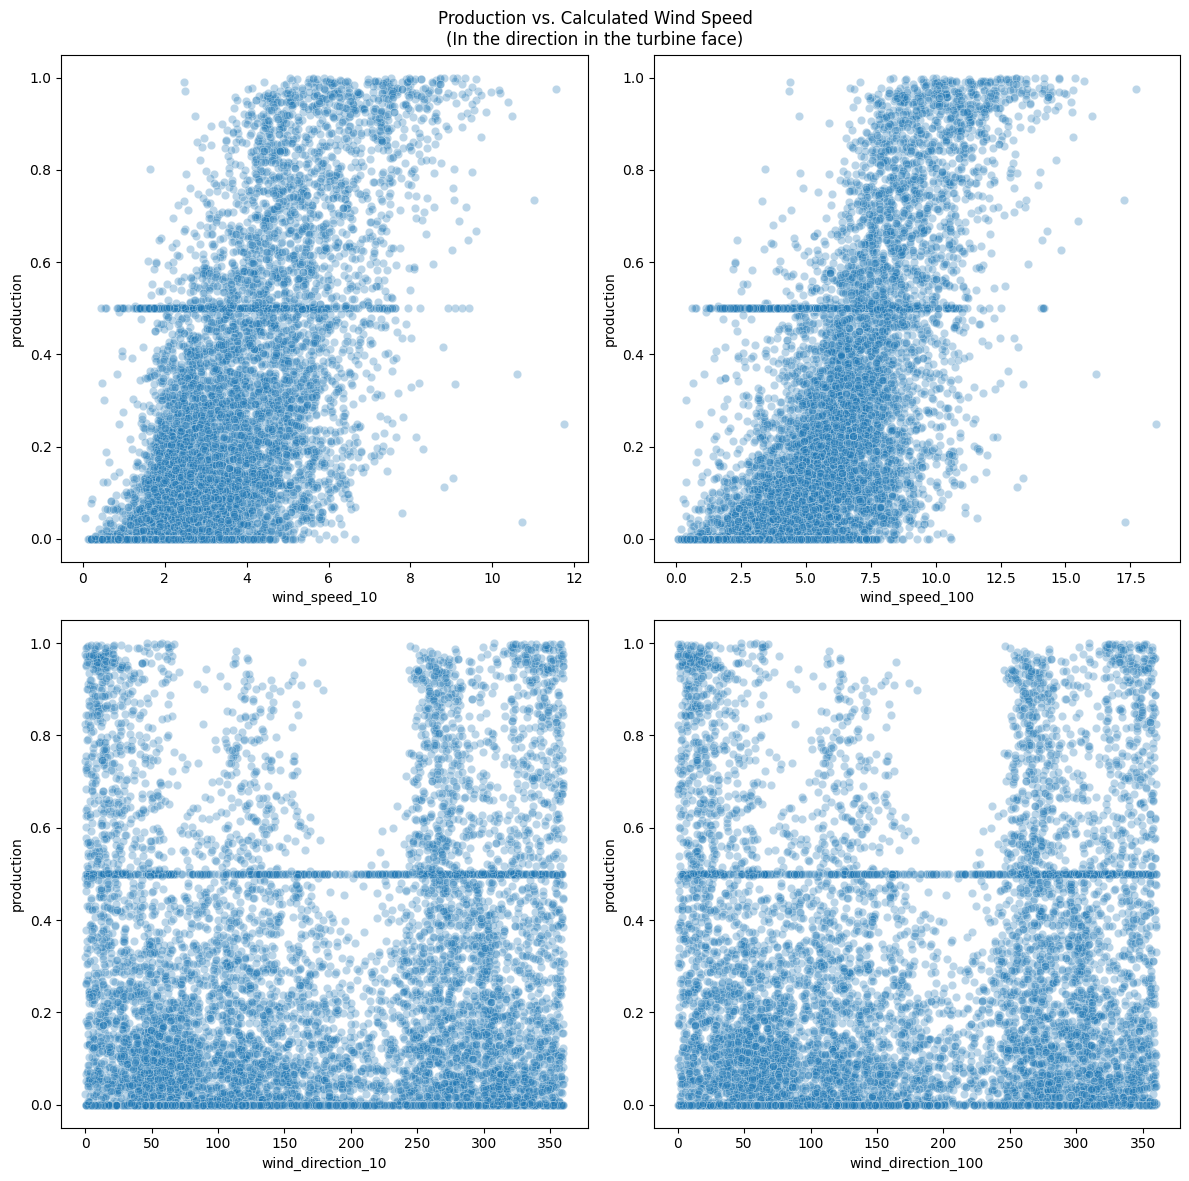

In [16]:
new_columns = ['wind_speed_10', 'wind_speed_100', 'wind_direction_10', 'wind_direction_100']
_, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()

for i, col in enumerate(new_columns):
     sns.scatterplot(data=df_train, x=col, y='production', ax = axs[i], alpha=0.3)


plt.suptitle('Production vs. Calculated Wind Speed\n(In the direction in the turbine face)')
plt.tight_layout()
plt.show()


In [17]:
df_train.corr()['production'].sort_values(ascending=False)

production            1.000000
wind_speed_100        0.672439
wind_speed_10         0.640421
u10                   0.318136
u100                  0.307901
wind_direction_100    0.080698
wind_direction_10     0.074878
date                 -0.048344
v10                  -0.128665
v100                 -0.143718
Name: production, dtype: float64

###  Observations:
-  Wind Speed in the face of the turbine provides a better correlation with production.
-  There seems to be a series of outliers at 50% production, based on the histogram and based on the scatter plots.
-  Lets screen these values out and replot.

## 5. Feature Engineering (Ingénierie des fonctionnalités)

In [18]:
#  Function to test models based on baseline and additional features.
# Define the models to be tested
def get_models():
    models = {
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'XGBoost': XGBRegressor(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(),
    }
    return models

# Function to evaluate all models and return a DataFrame of results
def evaluate_models(X, y, scoring='neg_mean_absolute_error', cv=5):
    models = get_models()
    results = []

    for name, model in models.items():
        # Use a pipeline to scale features if necessary (for models sensitive to feature scaling)
        if name in ['KNN', 'SVR']:
            pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
        else:
            pipeline = model
        
        # Perform cross-validation
        cv_mse = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv)
        cv_mae = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv)
        cv_r2 = cross_val_score(pipeline, X, y, scoring='r2', cv=cv)
        
        # Store the results in the list
        results.append({
            'Model': name,
            'MSE (Mean)': -cv_mse.mean(),
            'MSE (Std)': cv_mse.std(),
            'MAE (Mean)': -cv_mae.mean(),
            'MAE (Std)': cv_mae.std(),
            'R² (Mean)': cv_r2.mean(),
            'R² (Std)': cv_r2.std()
        })
    
    # Return results as a DataFrame
    return pd.DataFrame(results)




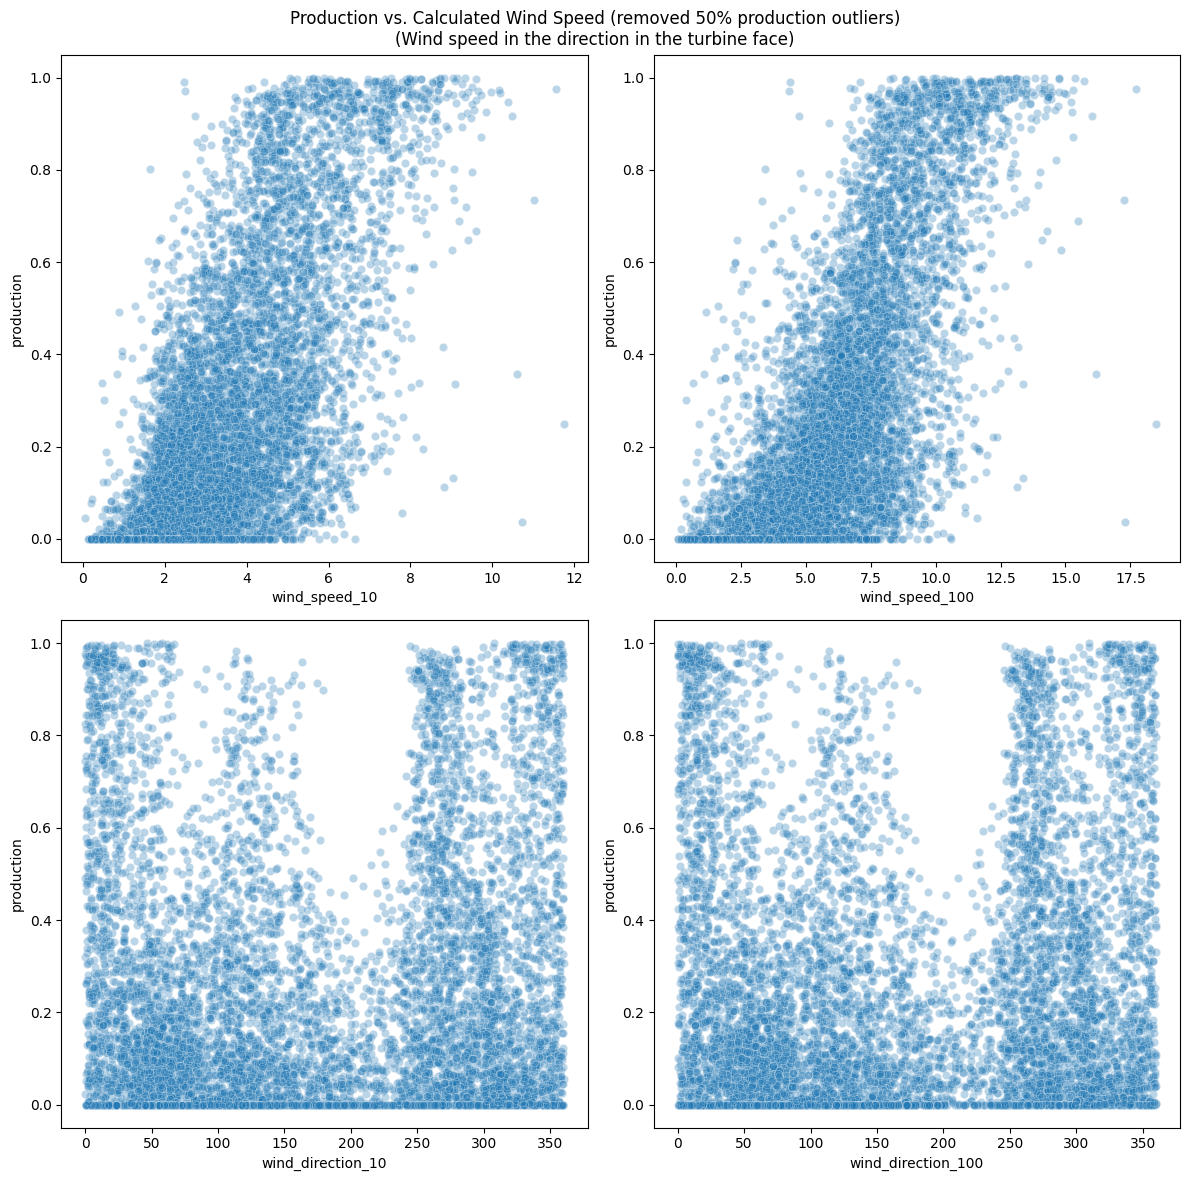

In [19]:
df_train = df_train[df_train['production'] != 0.50]

new_columns = ['wind_speed_10', 'wind_speed_100', 'wind_direction_10', 'wind_direction_100']
_, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()

for i, col in enumerate(new_columns):
     sns.scatterplot(data=df_train, x=col, y='production', ax = axs[i], alpha=0.3)

plt.suptitle('Production vs. Calculated Wind Speed (removed 50% production outliers)\n(Wind speed in the direction in the turbine face)')
plt.tight_layout()
plt.show()

### Wind Direction Bins
-  Does windspeed vs. Power look different at each 20 degree bin of wind direction.
-  Bin the wind_direction data into 20 degree increments and create a new column with the bin extents.

####  Hour of day, Month



In [20]:
df_train['hour'] = df_train.date.dt.hour
df_train['month'] = df_train.date.dt.month

In [21]:
#  Does windspeed vs. Power look different at each 5 degree bin of wind direction.
#  Bin the wind_direction data into 10 degree increments and create a new column with the bin extents.
df_train['wind_direction_10_bin'] = pd.cut(df_train['wind_direction_10'], bins=18)
df_train['wind_direction_10_bin_center'] = df_train['wind_direction_10_bin'].apply(lambda x: round(x.mid))

df_train['wind_direction_100_bin'] = pd.cut(df_train['wind_direction_100'], bins=18)
df_train['wind_direction_100_bin_center'] = df_train['wind_direction_100_bin'].apply(lambda x: round(x.mid))

df_train.head()

#  Then group by the bin extends or create a filter and plot the production vs. the wind speed in each wind direction bin

date       u10       v10      u100      v100  production  \
0 2020-01-01 01:00:00  2.124600 -2.681966  2.864280 -3.666076    0.000000   
1 2020-01-01 02:00:00  2.521695 -1.796960  3.344859 -2.464761    0.054879   
2 2020-01-01 03:00:00  2.672210 -0.822516  3.508448 -1.214093    0.110234   
3 2020-01-01 04:00:00  2.457504 -0.143642  3.215233 -0.355546    0.165116   
4 2020-01-01 05:00:00  2.245898  0.389576  2.957678  0.332701    0.156940   

   wind_speed_10  wind_speed_100  wind_direction_10  wind_direction_100  hour  \
0       3.421530        4.652334         308.385561          308.000265     1   
1       3.096451        4.154892         324.526320          323.614219     2   
2       2.795932        3.712577         342.891438          340.911902     3   
3       2.461699        3.234831         356.654840          353.689764     4   
4       2.279435        2.976332           9.840676            6.418062     5   

   month wind_direction_10_bin wind_direction_10_bin_center  \
0      1    (300.005, 320.002]                          310   
1      1    (320.002, 339.998]                          330   
2      1    (339.998, 359.995]                          350   
3      1    (339.998, 359.995]                          350   
4      1      (-0.306, 20.051]                           10   

  wind_direction_100_bin wind_direction_100_bin_center  
0       (300.003, 320.0]                           310  
1       (320.0, 339.998]                           330  
2     (339.998, 359.995]                           350  
3     (339.998, 359.995]                           350  
4       (-0.319, 20.039]                            10

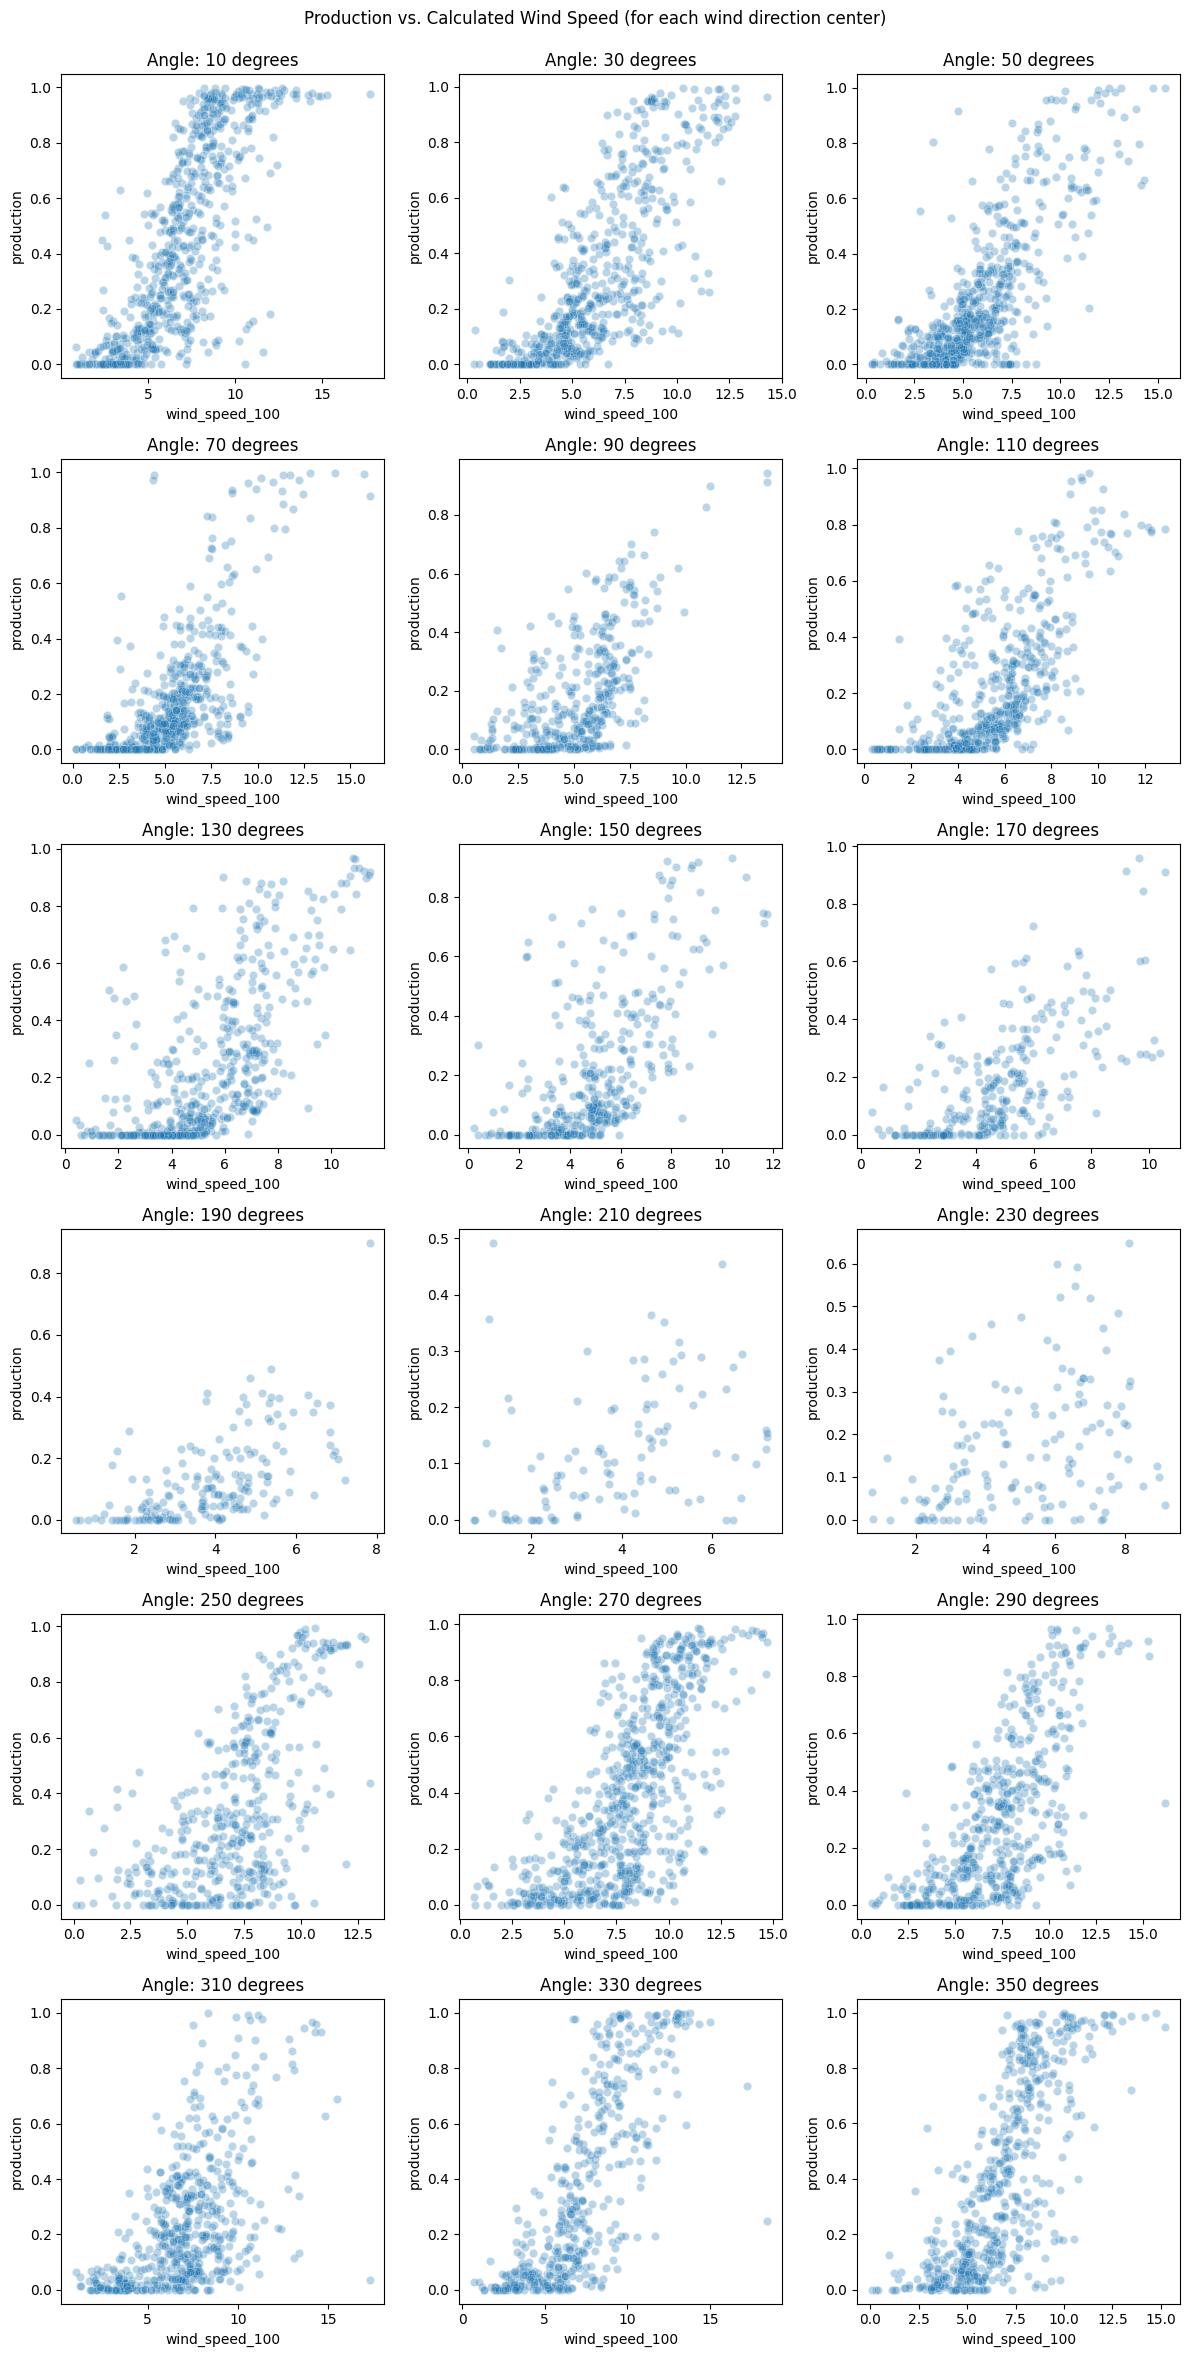

In [22]:
# # Make a plot of production vs. wind speed for each wind direction.

deg_bin_columns = list(df_train['wind_direction_100_bin_center'].unique().sort_values())
_, axs = plt.subplots(6, 3, figsize=(12,24))
axs = axs.flatten()

for i, col in enumerate(deg_bin_columns):
    filter = df_train['wind_direction_100_bin_center'] == col
    sns.scatterplot(data=df_train[filter], x='wind_speed_100', y='production', ax = axs[i], alpha=0.3)
    axs[i].set_title(f'Angle: {col} degrees')


plt.suptitle('Production vs. Calculated Wind Speed (for each wind direction center)\n\n')
plt.tight_layout()
plt.show()


In [23]:
#  Test a few models to see how close we predict the Wind Power Production.
#  Could the wind speed prediction be off either based on a time shift or that the wind speed is incorrect?
#  would it be better to create a prediction based on a mean wind speed?  averaged over several minutes, hours?

X = df_train[orig_columns[1:]].copy()
y = X.pop('production')

evaluate_models(X, y)


Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.066849   0.011419    0.181419   0.020651   0.133950   
1      RandomForest    0.038224   0.008133    0.142730   0.018851   0.500926   
2  GradientBoosting    0.036023   0.007357    0.141553   0.017823   0.531416   
3           XGBoost    0.040654   0.009380    0.144727   0.020381   0.469557   
4               KNN    0.042066   0.008198    0.149096   0.018301   0.453018   
5               SVR    0.034618   0.007946    0.136994   0.018928   0.547947   

   R² (Std)  
0  0.185075  
1  0.134397  
2  0.120726  
3  0.150525  
4  0.133948  
5  0.124797

In [24]:
#  run model with above columns and the hour of the day
orig_columns_plus_hr = ['hour', 'u10', 'v10', 'u100', 'v100', 'production']

X = df_train[orig_columns_plus_hr].copy()
y = X.pop('production')

evaluate_models(X, y)


Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.063590   0.013727    0.176698   0.022933   0.186578   
1      RandomForest    0.035865   0.008636    0.138583   0.020821   0.533620   
2  GradientBoosting    0.034491   0.007648    0.138464   0.018646   0.550941   
3           XGBoost    0.038312   0.008937    0.141503   0.020311   0.506203   
4               KNN    0.041611   0.008818    0.146673   0.019545   0.462825   
5               SVR    0.033046   0.007946    0.133177   0.019618   0.570221   

   R² (Std)  
0  0.178579  
1  0.122853  
2  0.122246  
3  0.122038  
4  0.122817  
5  0.117759

In [25]:
#  run model with above columns and the hour of the day, month of year
orig_columns_plus_hr_mnth = ['hour', 'month', 'u10', 'v10', 'u100', 'v100', 'production']

X = df_train[orig_columns_plus_hr_mnth].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.060539   0.010405    0.171330   0.017975   0.227764   
1      RandomForest    0.037380   0.008508    0.138524   0.019302   0.518158   
2  GradientBoosting    0.036506   0.008060    0.143594   0.016846   0.520913   
3           XGBoost    0.039765   0.008288    0.143459   0.016913   0.480643   
4               KNN    0.054212   0.010060    0.166855   0.016685   0.298175   
5               SVR    0.040225   0.008708    0.145588   0.018538   0.469710   

   R² (Std)  
0  0.148366  
1  0.129031  
2  0.142356  
3  0.133530  
4  0.167059  
5  0.164311

In [26]:
#  run model with calculated wind speed and wind direction
columns_ws_wd = ['hour', 'wind_speed_10', 'wind_speed_100', 'wind_direction_10', 'wind_direction_100', 'production']

X = df_train[columns_ws_wd].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.063489   0.013892    0.175514   0.021192   0.191296   
1      RandomForest    0.035817   0.008855    0.137847   0.020992   0.536937   
2  GradientBoosting    0.034380   0.008128    0.137794   0.019884   0.551617   
3           XGBoost    0.039214   0.009615    0.143079   0.020839   0.494827   
4               KNN    0.038647   0.009169    0.141693   0.020068   0.501984   
5               SVR    0.034105   0.008257    0.137353   0.019952   0.556506   

   R² (Std)  
0  0.170201  
1  0.125207  
2  0.128323  
3  0.126101  
4  0.124554  
5  0.121162

In [27]:
#  run model with wind speed, at 10m and 100m
columns_ws = ['hour', 'wind_speed_10', 'wind_speed_100', 'production']

X = df_train[columns_ws].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.073065   0.013639    0.192106   0.021356   0.059863   
1      RandomForest    0.041965   0.010615    0.150381   0.022046   0.454962   
2  GradientBoosting    0.038013   0.009471    0.145442   0.021440   0.507398   
3           XGBoost    0.044185   0.011236    0.152706   0.022888   0.434027   
4               KNN    0.044285   0.010981    0.154108   0.022515   0.429854   
5               SVR    0.038433   0.009522    0.147022   0.019962   0.500984   

   R² (Std)  
0  0.196662  
1  0.143448  
2  0.134773  
3  0.136879  
4  0.144573  
5  0.134517

In [28]:
#  Run model with hour, calculated wind speed, and wind direction heading.
df_train[['wind_direction_10_bin_center', 'wind_direction_100_bin_center']] = df_train[['wind_direction_10_bin_center', 'wind_direction_100_bin_center']].astype('int')
columns_ws_wdb = ['hour', 'wind_speed_10', 'wind_speed_100', 'wind_direction_10_bin_center', 'wind_direction_100_bin_center',  'production']

X = df_train[columns_ws_wdb].copy()
y = X.pop('production')

evaluate_models(X, y)


Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.062921   0.011497    0.174329   0.018995   0.200099   
1      RandomForest    0.036845   0.008573    0.139497   0.020802   0.522873   
2  GradientBoosting    0.034366   0.008413    0.137630   0.020474   0.551718   
3           XGBoost    0.039294   0.009151    0.142073   0.019326   0.496252   
4               KNN    0.039116   0.009227    0.142145   0.019474   0.495601   
5               SVR    0.034074   0.008239    0.137123   0.019544   0.556907   

   R² (Std)  
0  0.174614  
1  0.124410  
2  0.130972  
3  0.114575  
4  0.125251  
5  0.121162

In [29]:
#  run model with hour, calculated wind speed, ws_ratio between heights, wind direction heading, 
df_train['ws_ratio'] = df_train['wind_speed_100'] /df_train['wind_speed_10']
columns_ws_wdb_wsr = ['hour', 'wind_speed_10', 'wind_speed_100', 'ws_ratio', 'wind_direction_10_bin_center', 'wind_direction_100_bin_center',  'production']


X = df_train[columns_ws_wdb_wsr].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.063095   0.011850    0.176107   0.018497   0.179419   
1      RandomForest    0.036149   0.008214    0.138152   0.020112   0.532506   
2  GradientBoosting    0.034188   0.008415    0.136743   0.020164   0.554290   
3           XGBoost    0.038406   0.008013    0.140897   0.018239   0.505773   
4               KNN    0.039485   0.009136    0.142691   0.019505   0.491506   
5               SVR    0.034020   0.008299    0.136731   0.019653   0.557822   

   R² (Std)  
0  0.162715  
1  0.119073  
2  0.128720  
3  0.108013  
4  0.121690  
5  0.119924

In [30]:
#  run model with original columns, hour of the day and wind speed ratio (also termed relative wind_shear)
orig_columns_plus_hr_wsr = ['hour', 'u10', 'v10', 'u100', 'v100', 'ws_ratio', 'production']

X = df_train[orig_columns_plus_hr_wsr].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.063629   0.010977    0.178658   0.020535   0.182911   
1      RandomForest    0.035277   0.008720    0.136199   0.021025   0.544765   
2  GradientBoosting    0.034592   0.007891    0.138117   0.019372   0.550001   
3           XGBoost    0.037866   0.007969    0.139395   0.018293   0.513437   
4               KNN    0.041250   0.008473    0.145640   0.017795   0.467962   
5               SVR    0.032678   0.007715    0.132304   0.019212   0.575650   

   R² (Std)  
0  0.189527  
1  0.116570  
2  0.121754  
3  0.102144  
4  0.115564  
5  0.111106

###  Interim Findings:
-  The original E-W and N-S wind speeds, hour of the day, and wind speed ratios were the best features so far.
-  The support vector machine model produced the best fit with this set of features.
-  The next best were the Random Forest and Gradient Boosting models
-  Could the difference between 10m and 100m wind direction contribute to wind turbine output changes?
-  What is the impact of different metrics of wind shear on production?
    - Absolute wind shear refers to the difference between wind speed at different heights.
    - Relative wind sheer refers to the ratio of winds speeds at different heights.
    - Wind shear exponent is calcualted as follows: $$\alpha = \frac{\ln\left(\frac{V_{100}}{V_{10}}\right)}{\ln(10)}$$
    - Test all the above and see what improves the model.
    


In [31]:
#  run model with original columns, hour of the day and wind speed ratio, and wind_veer
#  estimated 'wind_veer' based on the difference between the 10m and 100m wind directions.
df_train['wind_veer'] = (df_train['wind_direction_100'] - df_train['wind_direction_10'])
orig_columns_plus_hr_wsr_wv = ['hour', 'u10', 'v10', 'u100', 'v100', 'ws_ratio', 'wind_veer', 'production']

X = df_train[orig_columns_plus_hr_wsr_wv].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.063567   0.013323    0.179465   0.022442   0.187608   
1      RandomForest    0.035141   0.008908    0.135748   0.020804   0.547302   
2  GradientBoosting    0.034429   0.008347    0.137171   0.020372   0.553459   
3           XGBoost    0.037955   0.008574    0.139720   0.018939   0.511113   
4               KNN    0.041434   0.008515    0.145814   0.017883   0.465113   
5               SVR    0.032704   0.007726    0.132553   0.019367   0.575219   

   R² (Std)  
0  0.150015  
1  0.118395  
2  0.120869  
3  0.110281  
4  0.118265  
5  0.111838

In [32]:
#  Add wind shear (difference between 100m and 10m wind speeds)  
#  run model with original columns, hour of the day wind_veer, and wind_shear 
#  estimated 'wind_veer' based on the difference between the 10m and 100m wind directions.
#  Estimated wind_shear (absolute difference between 100m and 10m heights) based on the calcuated wind speed for simplicity
df_train['wind_shear'] = (df_train['wind_speed_100'] - df_train['wind_speed_10'])
orig_columns_plus_hr_wv_ws = ['hour', 'u10', 'v10', 'u100', 'v100', 'wind_veer', 'wind_shear', 'production']

X = df_train[orig_columns_plus_hr_wv_ws].copy()
y = X.pop('production')

evaluate_models(X, y)

Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.061436   0.013222    0.175402   0.021109   0.207444   
1      RandomForest    0.035483   0.008994    0.136219   0.021358   0.542073   
2  GradientBoosting    0.035166   0.008766    0.138181   0.020936   0.541942   
3           XGBoost    0.038842   0.010115    0.140893   0.022133   0.501352   
4               KNN    0.040970   0.008722    0.144889   0.018041   0.469391   
5               SVR    0.033094   0.007990    0.133248   0.019410   0.570967   

   R² (Std)  
0  0.160345  
1  0.120246  
2  0.131101  
3  0.124993  
4  0.128913  
5  0.112939

In [33]:
#  now lets calculate the wind shear exponent alpha

df_train['ws_alpha'] =  np.log(df_train['wind_speed_100']/df_train['wind_speed_10']) / np.log(10)

orig_columns_plus_hr_wsalpha = ['hour', 'u10', 'v10', 'u100', 'v100', 'ws_alpha', 'production']

X = df_train[orig_columns_plus_hr_wsalpha].copy()
y = X.pop('production')
evaluate_models(X, y)


Model  MSE (Mean)  MSE (Std)  MAE (Mean)  MAE (Std)  R² (Mean)  \
0      DecisionTree    0.063475   0.011306    0.177445   0.019996   0.168849   
1      RandomForest    0.035417   0.008844    0.136336   0.020678   0.544313   
2  GradientBoosting    0.034589   0.007898    0.138115   0.019370   0.549980   
3           XGBoost    0.037866   0.007969    0.139395   0.018293   0.513437   
4               KNN    0.041002   0.008615    0.145044   0.017827   0.471318   
5               SVR    0.032462   0.007627    0.131898   0.019058   0.578612   

   R² (Std)  
0  0.190318  
1  0.118872  
2  0.121584  
3  0.102144  
4  0.116381  
5  0.109369

-  Next try the cube of wind speeds, hour, ws_alpha to see if the model is improved.
    -  "Power output from wind is proportional to the cube of wind speed, so even slight increases in wind speed at higher altitudes can lead to substantial gains in energy production."
-  Is it worth trying to run a KNN classifier to find new 'label' features based on the final subset of features?  This may help me further refine the model.
-  Is it worth using Principal Component Analysis to look at PCA components or to identify new features.
-  Consider plotting the y_actual vs. y_predicted distribution for the final model.

#### Notes:
-  Wind veer did not improve the model.
-  Wind Shear Exponent had the biggest impact on the model and was a better predictor than absolute wind shear or relative wind shear (ws_ratio)
-  The cube of wind speeds did not improve the model.
-  The final list of features included  [`hour`, `u10`, `v10`, 'u100', `v100`, `ws_alpha`, `production`]

In [34]:
#  Wind Shear exponent Alpha below
df_train['ws_alpha'].describe()

count    8248.000000
mean        0.246431
std         0.105148
min        -0.548249
25%         0.157564
50%         0.232941
75%         0.327213
max         1.098193
Name: ws_alpha, dtype: float64

## 6. Modeling and Evaluation (Modélisation et évaluation)

In [37]:
#  Tune the Support Vector Machine Model based on the final list of features.  Calculate the cross validation score of the tuned model.
features = ['hour', 'u10', 'v10', 'u100', 'v100', 'ws_alpha', 'production']

X = df_train[features].copy()
y = X.pop('production')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define a pipeline with scaling and SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define the parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__kernel': ['rbf'],  # options include 'rbf', 'linear', 'poly'
    'svr__gamma': [0.01, 0.1, 1],
    'svr__epsilon': [0.1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)


Best parameters: {'svr__C': 1, 'svr__epsilon': 0.1, 'svr__gamma': 1, 'svr__kernel': 'rbf'}
Best cross-validated score: -0.12265869841072055


In [39]:
# Get the best estimator
best_svr = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_svr.predict(X_test)

# Calculate metrics (e.g., Mean Squared Error)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Absolute Error: 0.11568071436974592
R^2 Score: 0.7050704241832986


In [40]:
df_test.head()

date       u10       v10      u100      v100
0 2021-01-01 00:00:00  3.103149  1.295629  4.146771  1.672058
1 2021-01-01 01:00:00  3.456026  1.799494  4.624995  2.329869
2 2021-01-01 02:00:00  3.716234  1.893639  4.987532  2.435546
3 2021-01-01 03:00:00  4.029650  2.195310  5.442522  2.855735
4 2021-01-01 04:00:00  4.200922  2.402018  5.703258  3.147100

## 7. Conclusions (Nettoyage des données)

-  A number of features were tested in the feature engineering section.
-  Features included calculated:
    - Hour of the Day
    - wind speed, wind direction based on E-W, N-S wind speed vectors provided
    - wind speed ratio (relative shear), 
    - absolute shear, 
    - Wind Shear Exponent
    - veer (Difference between wind direction at 10m and 100m), 
    - "Binned" Wind Directions to capture similar wind directions into 18 different bins.
-  The features which resulted in the lowest Mean Absolute Error were hour, raw wind speed measurements provided and the wind shear exponent.
-  These features were tested in 6 different models.
-  The SVM model produced the lower Mean Absolute Error of 0.11568 using cross validation.

## 8. Submissions (Soumissions)

In [42]:
#  Fit the model with the full set of training data

grid_search.fit(X, y)
best_svr = grid_search.best_estimator_

In [44]:
#  Prepare the test data set using the same feature engineering applied on the final training set.

df_test['hour'] = df_test.date.dt.hour
df_test['wind_speed_10'] = np.sqrt(df_test.u10**2 + df_test.v10**2)
df_test['wind_speed_100'] = np.sqrt(df_test.u100**2 + df_test.v100**2)
df_test['ws_alpha'] = np.log(df_test['wind_speed_100']/df_test['wind_speed_10']) / np.log(10)
df_test.head()

date       u10       v10      u100      v100  hour  \
0 2021-01-01 00:00:00  3.103149  1.295629  4.146771  1.672058     0   
1 2021-01-01 01:00:00  3.456026  1.799494  4.624995  2.329869     1   
2 2021-01-01 02:00:00  3.716234  1.893639  4.987532  2.435546     2   
3 2021-01-01 03:00:00  4.029650  2.195310  5.442522  2.855735     3   
4 2021-01-01 04:00:00  4.200922  2.402018  5.703258  3.147100     4   

   wind_speed_10  wind_speed_100  ws_alpha  
0       3.362765        4.471184  0.123726  
1       3.896446        5.178694  0.123552  
2       4.170883        5.550438  0.124099  
3       4.588842        6.146240  0.126906  
4       4.839157        6.513939  0.129074

In [46]:
features = ['hour', 'u10', 'v10', 'u100', 'v100', 'ws_alpha']
X = df_test[features].copy()

y_predict = best_svr.predict(X)

df_submission = pd.DataFrame({'date': df_test['date'], 'production': y_predict})
df_submission.to_csv('submission.csv', index=False)